In [1]:
import resampy
import os
import glob
import resampy
import librosa
import numpy as np
import pandas as pd
import pickle


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers 

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [2]:
import tensorflow as tf 
from tensorflow.python.client import device_lib

print(device_lib.list_local_devices()[1] )


name: "/device:GPU:0"
device_type: "GPU"
locality {
  bus_id: 1
}
incarnation: 277708940271151769
physical_device_desc: "device: 0, name: METAL, pci bus id: <undefined>"
xla_global_id: -1



2024-07-26 22:11:38.777714: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Pro
2024-07-26 22:11:38.777749: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 18.00 GB
2024-07-26 22:11:38.777759: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 6.00 GB
2024-07-26 22:11:38.777811: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-07-26 22:11:38.777839: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [3]:
import librosa
print(librosa.__version__)

0.10.2.post1


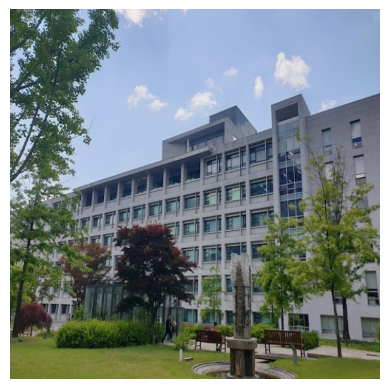

In [4]:
import cv2
import matplotlib.pyplot as plt
# 이미지 파일을 읽어옵니다
image = cv2.imread('/Users/minseok/Desktop/ict 공모전/음성데이터/이미지.jpg')

# 이미지를 30x130으로 리사이즈합니다
resized_image = cv2.resize(image, (500, 500))
# OpenCV는 기본적으로 BGR 색상 공간을 사용하므로, RGB로 변환
resized_image_rgb = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)

# 이미지 출력
plt.imshow(resized_image_rgb)
plt.axis('off')  # 축 제거
plt.show()

high_texture 500
low_texture 500


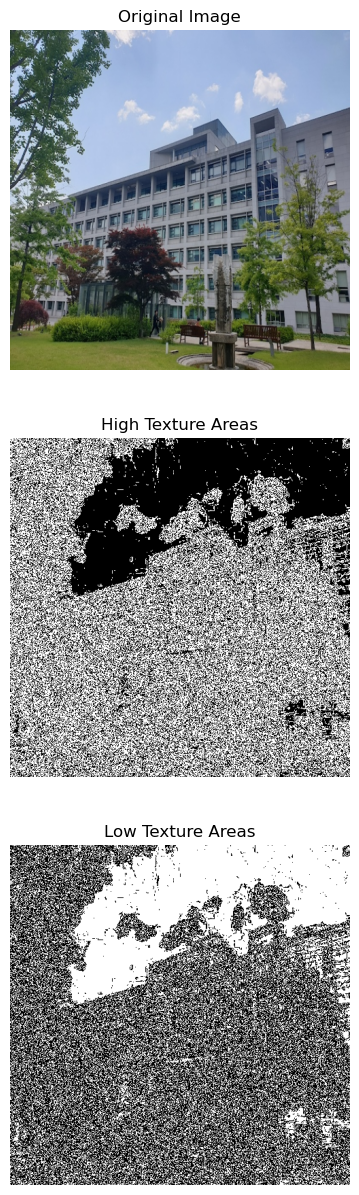

In [37]:
import scipy.ndimage

# Sobel 필터 정의
sobel_x = np.array([[1, 0, -1], [2, 0, -2], [1, 0, -1]])
sobel_y = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]])

# 그라디언트 계산
grad_x = scipy.ndimage.convolve(resized_image_rgb[:, :, 0], sobel_x)  # Red channel
grad_y = scipy.ndimage.convolve(resized_image_rgb[:, :, 0], sobel_y)  # Red channel

# 그라디언트의 크기 계산
grad_mag = np.sqrt(grad_x**2 + grad_y**2)

# 그라디언트 크기의 임계값 설정 
threshold = np.median(grad_mag[grad_mag > 0]) if np.any(grad_mag > 0) else 0

# 텍스처가 많은 부분과 적은 부분을 구분
high_texture = grad_mag >= threshold
low_texture = grad_mag < threshold

print( 'high_texture', len(high_texture))
print( 'low_texture', len(low_texture))
# 결과를 시각적으로 확인
plt.figure(figsize=(10, 15))

plt.subplot(3, 1, 1)
plt.title('Original Image')
plt.imshow(resized_image_rgb)
plt.axis('off')

plt.subplot(3, 1, 2)
plt.title('High Texture Areas')
plt.imshow(high_texture, cmap='gray')
plt.axis('off')

plt.subplot(3, 1, 3)
plt.title('Low Texture Areas')
plt.imshow(low_texture, cmap='gray')
plt.axis('off')

plt.show()


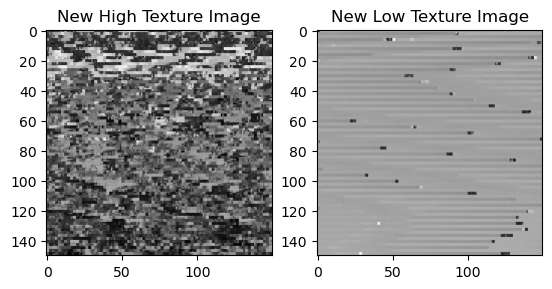

In [39]:
patch_size = 2  # 예: 4x4 패치


def extract_patches(data, mask, patch_size, grad_mag):
    patches = []
    grad_mags = []
    rows, cols = data.shape
    for i in range(0, rows - patch_size + 1, patch_size):
        for j in range(0, cols - patch_size + 1, patch_size):
            patch = data[i:i+patch_size, j:j+patch_size]
            patch_mask = mask[i:i+patch_size, j:j+patch_size]
            if np.all(patch_mask) and not np.any(patch == 0):
                patches.append(patch)
                grad_mags.append(np.mean(grad_mag[i:i+patch_size, j:j+patch_size]))
    return patches, grad_mags


high_texture_patches, high_texture_grad_mags = extract_patches(resized_image_rgb[:, :, 0], high_texture, patch_size, grad_mag)
low_texture_patches, low_texture_grad_mags = extract_patches(resized_image_rgb[:, :, 0], low_texture, patch_size, grad_mag)

import random

# 패치를 그라디언트 크기 순으로 정렬
high_texture_patches_tts = [x for _, x in sorted(zip(high_texture_grad_mags, high_texture_patches),key=lambda pair: pair[0], reverse=True)]
low_texture_patches_tts = [y for _, y in sorted(zip(low_texture_grad_mags, low_texture_patches),key=lambda pair: pair[0], reverse=True)]

# 새 이미지의 크기 정의 (예: 20x100 크기)
new_image_height = 150
new_image_width = 150

# 새로운 이미지 생성
new_image_high_texture = np.zeros((new_image_height, new_image_width))
new_image_low_texture = np.zeros((new_image_height, new_image_width))

# 패치를 임의 위치에 배치
def place_patches(patches, new_image, patch_size):
    idx = 0
    rows, cols = new_image.shape
    for i in range(0, rows, patch_size):
        for j in range(0, cols, patch_size):
            if idx < len(patches):
                new_image[i:i+patch_size, j:j+patch_size] = patches[idx]
                idx += 1
    return new_image

new_image_high_texture = place_patches(high_texture_patches, new_image_high_texture, patch_size)
new_image_low_texture = place_patches(low_texture_patches, new_image_low_texture, patch_size)

vmin = min(new_image_high_texture.min(), new_image_low_texture.min())
vmax = max(new_image_high_texture.max(), new_image_low_texture.max())

# 결과를 시각적으로 확인 (옵션)
plt.subplot(1, 2, 1)
plt.title('New High Texture Image')
plt.imshow(new_image_high_texture, cmap='gray', vmin=vmin, vmax=vmax)

plt.subplot(1, 2, 2)
plt.title('New Low Texture Image')
plt.imshow(new_image_low_texture, cmap='gray', vmin=vmin, vmax=vmax)

plt.show()

(500, 500)


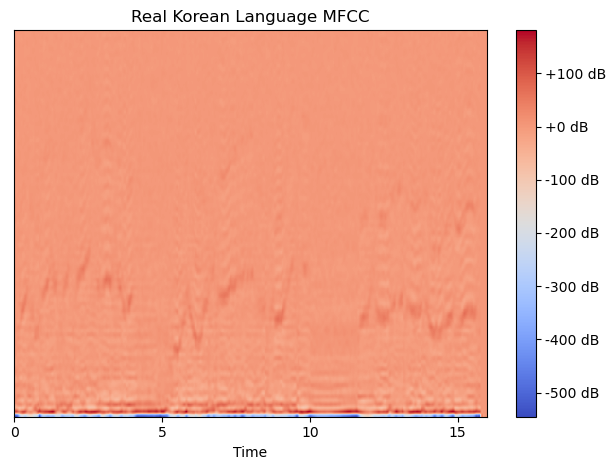

In [6]:
import librosa
import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage

hertz = 16000
number_mfcc = 100
desired_shape = (500, 500)
max_pad_len = 300  # or some other maximum length you want to allow

# Load the audio file
audio, sample_rate = librosa.load('/Users/minseok/Desktop/ict 공모전/음성데이터/eval_clean/KsponSpeech_E00113.wav', res_type='kaiser_fast', sr=hertz)

# Compute the MFCCs
mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=number_mfcc)

# Determine appropriate padding or truncation
if mfccs.shape[1] < max_pad_len:
    pad_width = max_pad_len - mfccs.shape[1]
    mfccs = np.pad(mfccs, pad_width=((0, 0), (0, pad_width)), mode='constant')
else:
    mfccs = mfccs[:, :max_pad_len]

# Resize the MFCCs to the desired shape (500, 500)
zoom_factors = (desired_shape[0] / mfccs.shape[0], desired_shape[1] / mfccs.shape[1])
resized_mfccs = scipy.ndimage.zoom(mfccs, zoom_factors)

print(resized_mfccs.shape)

# Display the resized MFCCs
plt.figure()
librosa.display.specshow(resized_mfccs, sr=hertz, x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('Real Korean Language MFCC')
plt.tight_layout()
plt.show()


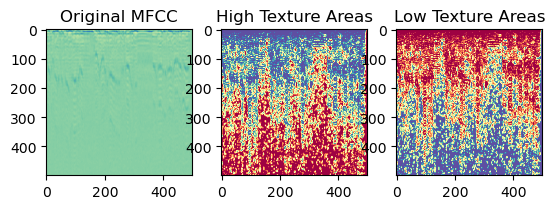

In [7]:
import numpy as np
import scipy.ndimage
import matplotlib.pyplot as plt


# Sobel 필터를 사용하여 그라디언트 계산
sobel_x = np.array([[1, 0, -1], [2, 0, -2], [1, 0, -1]])
sobel_y = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]])

grad_x = scipy.ndimage.convolve(resized_mfccs, sobel_x)
grad_y = scipy.ndimage.convolve(resized_mfccs, sobel_y)

# 그라디언트의 크기 계산
grad_mag = np.sqrt(grad_x**2 + grad_y**2)
non_zero_grad_mag = grad_mag[grad_mag > 0]

# 그라디언트 크기의 임계값 설정 
threshold = np.median(non_zero_grad_mag)
# 텍스처가 많은 부분과 적은 부분을 구분
high_texture = grad_mag >= threshold
low_texture = grad_mag < threshold

# 결과를 시각적으로 확인 (옵션)
plt.subplot(1, 3, 1)
plt.title('Original MFCC')
plt.imshow(resized_mfccs, cmap='Spectral')

plt.subplot(1, 3, 2)
plt.title('High Texture Areas')
plt.imshow(high_texture, cmap='Spectral')

plt.subplot(1, 3, 3)
plt.title('Low Texture Areas')
plt.imshow(low_texture, cmap='Spectral')

plt.show()


21024
21420


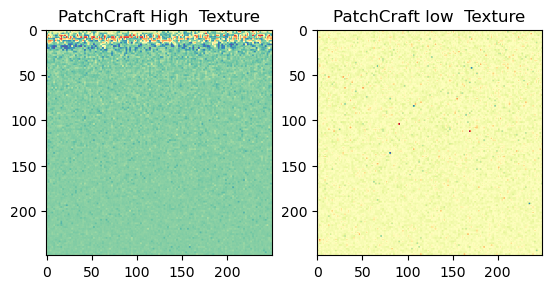

In [11]:
patch_size = 2  # 예: 4x4 패치

def extract_patches(data, mask, patch_size, grad_mag):
    patches = []
    grad_mags = []
    rows, cols = data.shape
    for i in range(0, rows - patch_size + 1, patch_size):
        for j in range(0, cols - patch_size + 1, patch_size):
            patch = data[i:i+patch_size, j:j+patch_size]
            patch_mask = mask[i:i+patch_size, j:j+patch_size]
            if np.all(patch_mask) and not np.any(patch == 0):
                patches.append(patch)
                grad_mags.append(np.mean(grad_mag[i:i+patch_size, j:j+patch_size]))
    return patches, grad_mags

high_texture_patches, high_texture_grad_mags = extract_patches(resized_mfccs, high_texture, patch_size, grad_mag)
low_texture_patches, low_texture_grad_mags = extract_patches(resized_mfccs, low_texture, patch_size, grad_mag)

# 패치를 그라디언트 크기 순으로 정렬
high_texture_patches = [x for _, x in sorted(zip(high_texture_grad_mags, high_texture_patches),key=lambda pair: pair[0], reverse=True)]
low_texture_patches = [x for _, x in sorted(zip(low_texture_grad_mags, low_texture_patches),key=lambda pair: pair[0], reverse=True)]
print(len(high_texture_patches))
print(len(low_texture_patches))

# 새 이미지의 크기 정의 (예: 20x100 크기)
new_image_height = 250
new_image_width = 250

# 새로운 이미지 생성
new_image_high_texture = np.zeros((new_image_height, new_image_width))
new_image_low_texture = np.zeros((new_image_height, new_image_width))

# 패치를 임의 위치에 배치
def place_patches(patches, new_image, patch_size):
    idx = 0
    rows, cols = new_image.shape
    for i in range(0, rows, patch_size):
        for j in range(0, cols, patch_size):
            if idx < len(patches):
                new_image[i:i+patch_size, j:j+patch_size] = patches[idx]
                idx += 1
    return new_image

new_image_high_texture = place_patches(high_texture_patches, new_image_high_texture, patch_size)
new_image_low_texture = place_patches(low_texture_patches, new_image_low_texture, patch_size)

# 결과를 시각적으로 확인 (옵션)
plt.subplot(1, 2, 1)
plt.title('PatchCraft High  Texture')
plt.imshow(new_image_high_texture, cmap='Spectral')

plt.subplot(1, 2, 2)
plt.title('PatchCraft low  Texture')
plt.imshow(new_image_low_texture, cmap='Spectral')

plt.show()


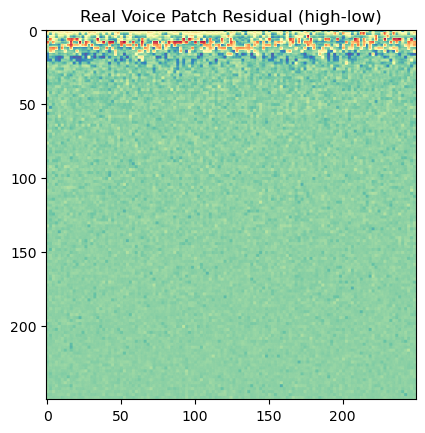

In [12]:
# 잔차 계산
residual = new_image_high_texture - new_image_low_texture
plt.title('Real Voice Patch Residual (high-low)')
plt.imshow(residual, cmap='Spectral')
